# Side-by-Side Visualization: Lattice-Based A* vs. MeshA*

This notebook provides a comparative visualization of two kinodynamic path planning algorithms designed for state-lattice graphs. The goal is to demonstrate the fundamental difference in how they explore the state space.

### 1. Algorithms Overview

* **Lattice-Based A\* (LBA\*):**
    * **Search Space:** discrete states $(x, y, \theta)$.
    * **Behavior:** The algorithm "jumps" from one valid state to another by expanding the entire bundle of motion primitives available at the current heading. It validates the complete trajectory of a primitive at once.
    * **Visual Pattern:** Expect to see a dense "forest" of motion primitives branching out.



* **MeshA\* (Proposed Method):**
    * **Search Space:** Extended Cells $u = (i, j, \Psi)$, representing a grid cell coupled with a configuration of primitive segments passing through it.
    * **Behavior:** The algorithm propagates "wave-like" through grid cells. While it respects kinodynamic constraints (via the configuration $\Psi$), it moves incrementally cell-by-cell.
    * **Key Advantage:** This granular traversal allows for **early pruning**. Unlike LBA*, MeshA* can discard a primitive *mid-trajectory* if the heuristic indicates that the path leading to its endpoint is suboptimal or blocked, significantly reducing the effective branching factor.

### 2. Visualization Legend

To facilitate the analysis, the visualization uses the following color coding:

#### Environment
* <span style="color:lightgreen">■</span> **Light Green Cells:** Obstacles.
* <span style="color:green">➔</span> **Green Arrow:** Start configuration.
* <span style="color:red">➔</span> **Red Arrow:** Goal configuration.

#### Search Process
* <span style="color:grey; opacity:0.5">■</span> **Grey Cells:** **CLOSED Set**. Projections of states (or extended cells) that have been fully expanded.
* <span style="color:orange; opacity:0.6">■</span> **Orange Cells:** **OPEN Set**. The current search frontier.
* <span style="color:darkmagenta">★</span> **Magenta Stars:** **Initial Extended Cells (Pivots)**. These are specific states where a primitive bundle completes and a new one can begin. They correspond directly to the lattice states in LBA*.

#### Edges (Motion Primitives)
* <span style="color:blue">―</span> **Blue Lines:** **Valid** motion primitives being considered or traversed.
* <span style="color:grey">--</span> **Dashed Grey Lines:** **Invalid** primitives (discarded due to collision).

* *Note:* LBA* reveals the entire bundle at the expansion step. MeshA* reveals the bundle only when reaching an *Initial Extended Cell*.



### 3. MeshA*: Interpretation of the Visualization & Effective Branching Factor

To correctly interpret the animations below, it is important to distinguish between the **search mechanism** and the **visual representation**:

1. **During Search (The "Blue" Phase):**
* MeshA* propagates strictly **cell-by-cell**.
* However, we visualize the full bundles of motion primitives (blue lines) originating from "Initial Cells". This is done to demonstrate that the grid propagation is not arbitrary; it is strictly guided by the underlying kinodynamic constraints of the control set.


2. **Post-Processing (The "Fade-Out" Phase):**
* After the path is found, a filtering step occurs. The visualization fades out a significant portion of the blue lines, leaving only a sparse **bright blue tree**.



**The Concept of "Effective Branching Factor":**
The remaining bright lines illustrate the **Effective Branching Factor** of the algorithm. The logic for fading out the other lines is based on **search redundancy**:

> **The Redundancy Criterion:** The faded primitives represent trajectories that did not impact the search progress. If we had removed these primitives from their bundles *a priori*, MeshA* would have expanded exactly the same set of grid cells.

Thus, the bright blue tree represents the **minimum set of primitives** required to reproduce the search state. This provides a visual proof of MeshA*'s efficiency: while LBA* is forced to expand the full bundle (high branching factor), MeshA\* implicitly prunes the vast majority of trajectories, resulting in a much lower *effective* branching factor.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage, clear_output

# Add path to common modules and tools
sys.path.append('../common')
from KC_structs import DiscreteState, ControlSet, Theta
from KC_searching import Map
from KC_graphics import draw_task_map, draw_task_map_fast

# Import visualization tools
from visualize import LiveVisualizer
from Py_LBA import VisualizableLBA
from Py_Mesh import VisualizableMesh, MeshInfo

# === CONFIGURATION ===
# We use a smaller 'additional' control set for visualization purposes.
# It contains fewer primitives than the 'base' set, making the graph less cluttered
# and easier to interpret visually.
CONTROL_SET_PATH = "../../data/add_control_set.txt"
MESH_INFO_PATH = "../../data/add_mesh_info.txt"

# Load Motion Primitives & Mesh Topology
theta = Theta()
cs = ControlSet(theta)
if os.path.exists(CONTROL_SET_PATH):
    cs.load_primitives(CONTROL_SET_PATH)
    print(f"Control Set loaded successfully.")
else:
    print(f"Error: Control Set file not found at {CONTROL_SET_PATH}")

if os.path.exists(MESH_INFO_PATH):
    mesh_info = MeshInfo(MESH_INFO_PATH, cs)
    print("Mesh Graph Topology loaded successfully.")
else:
    print(f"Error: Mesh Info file not found at {MESH_INFO_PATH}")

Control Set loaded successfully.
Mesh Graph Topology loaded successfully.


### Experiment 1: Qualitative Comparison

In this experiment, we run both algorithms on the same map instance.

**Observations to make:**
1.  **LBA\* (Top/First):** Notice how the search frontier (Orange) expands broadly. At each step, long blue tentacles (primitives) reach out, often into areas that are blocked or irrelevant.
2.  **MeshA\* (Bottom/Second):** Observe the flow. The search progresses cell-by-cell. Notice that blue lines (primitives) only originate from Magenta stars (Initial Cells).

In [2]:
# Map
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''
task_map = Map()
task_map.convert_string_to_cells(map_str)

start = DiscreteState(8, 0, 12)
goal = DiscreteState(12, 27, 0)

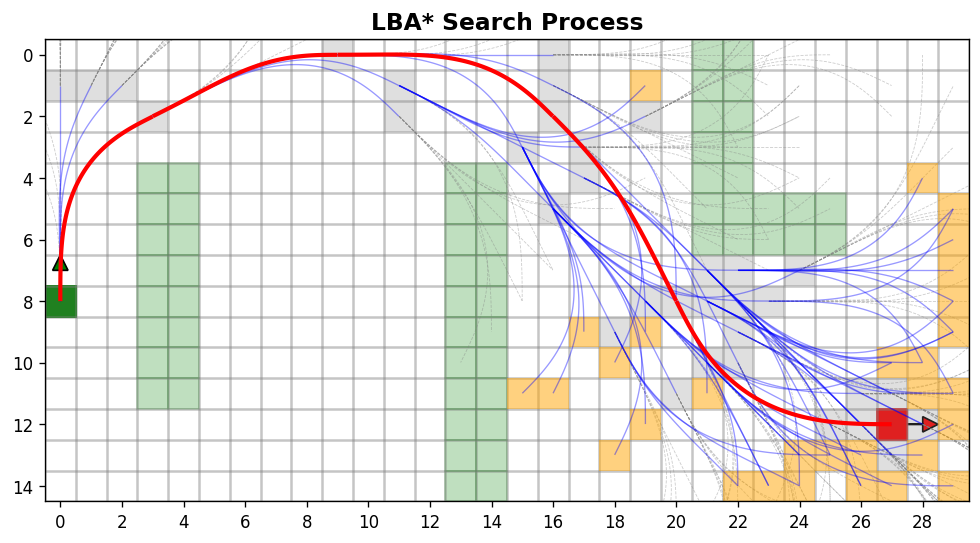

In [3]:
# === 1. Run Lattice-Based A* ===
print("Running LBA*...")
viz_lba = LiveVisualizer(
    draw_task_map, task_map, start, goal, theta_config=theta,
    title="LBA* Search Process", figsize=(10, 5), dpi=120
)

lba = VisualizableLBA(task_map, cs, theta)
# update_freq: Draw a frame every 'update_freq' expansions
found_lba = lba.run(start, goal, visualizer=viz_lba, update_freq=1)

# Save and Cleanup
# viz_lba.save_gif("../../images/lba_demo.gif", fps=5, final_pause=1.5)
plt.close(viz_lba.fig)  # Prevents the figure from remaining open in memory

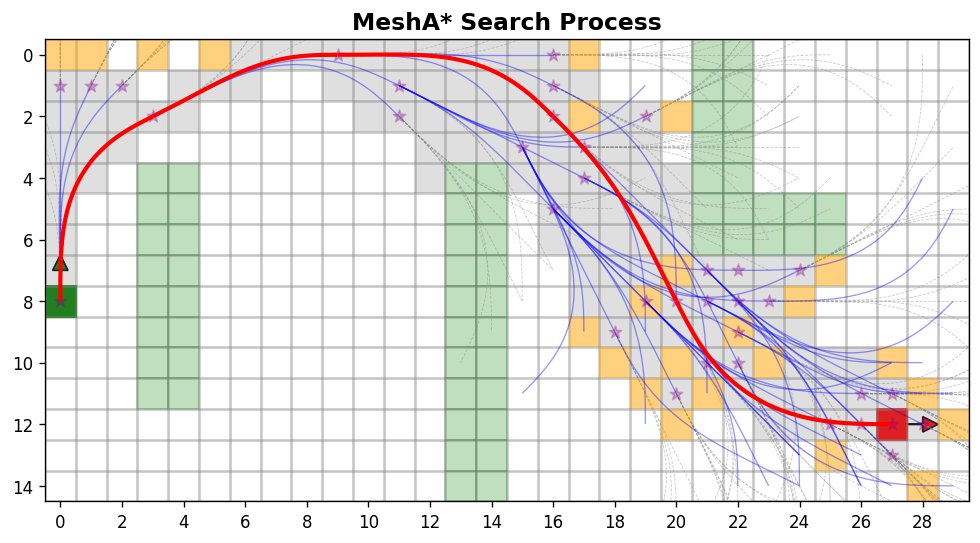

In [4]:
# === 2. Run MeshA* ===
print("Running MeshA*...")
viz_mesh = LiveVisualizer(
    draw_task_map, task_map, start, goal, theta_config=theta,
    title="MeshA* Search Process", figsize=(10, 5), dpi=120
)

mesh = VisualizableMesh(task_map, mesh_info, cs, theta)
found_mesh = mesh.run(start, goal, visualizer=viz_mesh, update_freq=1)

# Save and Cleanup
# viz_mesh.save_gif("../../images/mesha_demo.gif", fps=25, final_pause=1.5)
plt.close(viz_mesh.fig)

### Experiment 2: Scalability Analysis on Large Maps

In this section, we evaluate the algorithms on a significantly larger, unstructured environment derived from the **MovingAI Benchmark** (a slice of the `Berlin_0_256` city map).

**Objective:**
To demonstrate the macroscopic behavior of the search frontiers and visually compare the density of the search trees when the problem scale increases.

**Visualization Mode:**
Due to the increased map size and the number of expanded states, we switch to **Fast Raster Mode** (`fast_draw=True`).

* Instead of rendering individual vector patches for every grid cell (which is computationally expensive), we directly manipulate a pixel buffer overlay (`imshow`).
* This allows for fluid real-time visualization of thousands of extended cells.

**Expected Outcome:**

* **LBA\*:** The algorithm exhibits a high branching factor, resulting in a very dense "cloud" of primitive trajectories covering the explored area. Every feasible motion is fully expanded.
* **MeshA\*:** The search propagation resembles a cleaner wavefront expansion. Crucially, the post-processing step will reveal a **low effective branching factor**: the "Essential Tree" (bright blue) will be significantly sparser than the LBA* cloud, confirming that MeshA* achieves the same coverage with drastically fewer effective edge evaluations.

In [5]:
with open("../../maps/Berlin_2_256.map", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(36, 60, 4)

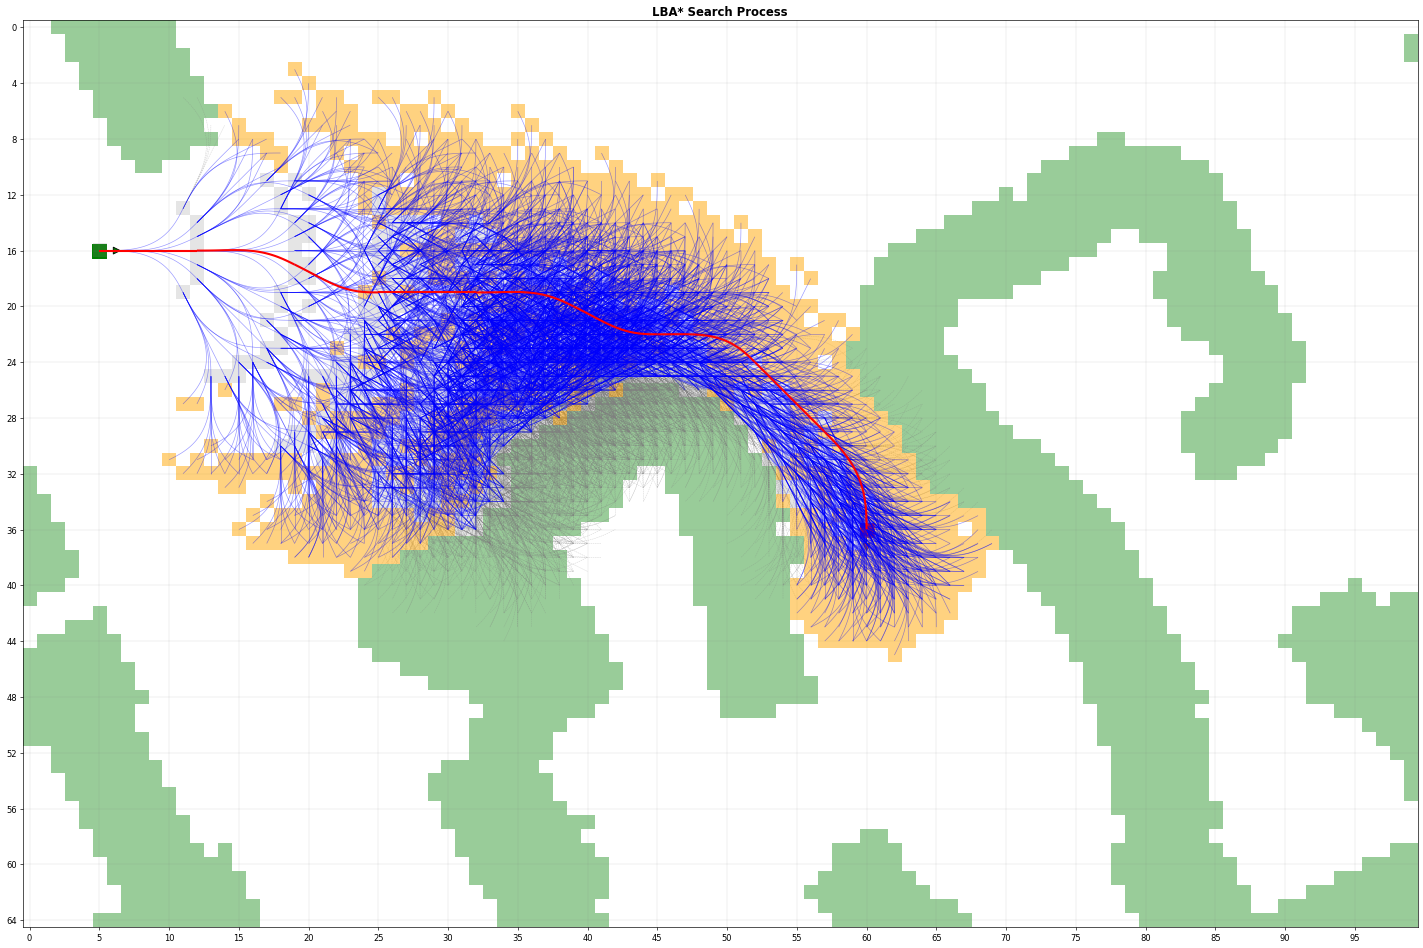

Animation successfully saved to ../../images/big_lba_demo.gif


In [7]:
# === 1. Run Lattice-Based A* ===
print("Running LBA*...")
viz_lba = LiveVisualizer(
    draw_task_map_fast, task_map, start, goal, theta_config=theta,
    title="LBA* Search Process", figsize=(30, 20), dpi=60,
    fast_draw=True
)

lba = VisualizableLBA(task_map, cs, theta)
found_lba = lba.run(start, goal, visualizer=viz_lba, update_freq=15)

viz_lba.save_gif("../../images/big_lba_demo.gif", fps=10, final_pause=1.5)

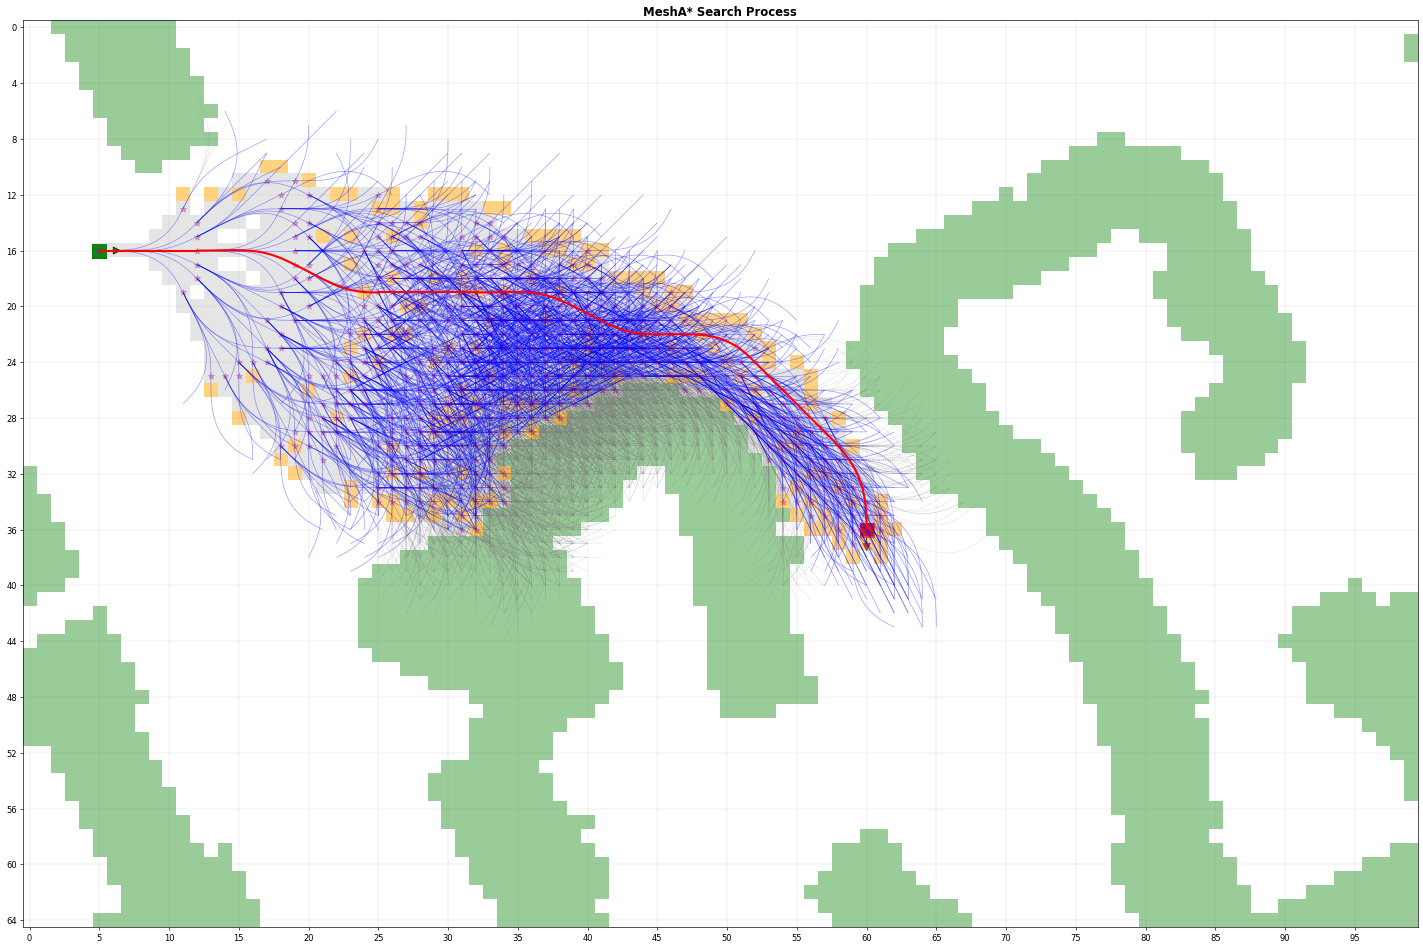

Animation successfully saved to ../../images/big_mesha_demo.gif


In [6]:
# === 2. Run MeshA* ===
print("Running MeshA*...")
viz_mesh = LiveVisualizer(
    draw_task_map_fast, task_map, start, goal, theta_config=theta,
    title="MeshA* Search Process", figsize=(30, 20), dpi=60,
    fast_draw=True
)

mesh = VisualizableMesh(task_map, mesh_info, cs, theta)
found_mesh = mesh.run(start, goal, visualizer=viz_mesh, update_freq=75)

# viz_mesh.save_gif("../../images/big_mesha_demo.gif", fps=20, final_pause=1.5)